In [3]:
import jax.numpy as jnp
from jax import grad, jit, vmap, jacfwd, jacrev
from jax import random
import jax.scipy.sparse as sp
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import networkx as nx
import pandas as pd
from tqdm.auto import tqdm, trange
from scipy.sparse import csc_matrix
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import claude as cl
from claude import observables as obs
from claude import constraints as const

In [5]:

N = 1000
ba = nx.barabasi_albert_graph(N,30)
gn = nx.scale_free_graph(1000)
ba_adj = np.asarray(nx.adj_matrix(ba).todense())
gn_adj = np.asarray(nx.adj_matrix(gn).todense())
d = np.array(ba_adj.sum(axis=0)).flatten()
dinv = 1/d

din = np.array(gn_adj.sum(axis=0)).flatten()
dout = np.array(gn_adj.sum(axis=1)).flatten()


In [6]:
def plot_adj(adj):
    plt.imshow(adj,cmap=matplotlib.cm.get_cmap('gray_r'),vmin=0,vmax=1)
    plt.colorbar()

# Connectivity

In [7]:
m = cl.GraphEnsemble(1000)
m.fit([const.Connectivity(343)], opt_kwargs={'nit':30,'fatol':1e-2,'disp':True})

0:  |F(x)| = 90778.5; step 1
1:  |F(x)| = 35825.7; step 1
2:  |F(x)| = 21192.6; step 1
3:  |F(x)| = 13178.7; step 1
4:  |F(x)| = 8598.3; step 1
5:  |F(x)| = 5808.91; step 1
6:  |F(x)| = 3793.04; step 1
7:  |F(x)| = 2441.64; step 1
8:  |F(x)| = 1560.83; step 1
9:  |F(x)| = 985.702; step 1
10:  |F(x)| = 609.768; step 1
11:  |F(x)| = 364.768; step 1
12:  |F(x)| = 207.141; step 1
13:  |F(x)| = 108.708; step 1
14:  |F(x)| = 50.6385; step 1
15:  |F(x)| = 19.7368; step 1
16:  |F(x)| = 5.92781; step 1
17:  |F(x)| = 1.23183; step 1
18:  |F(x)| = 0.155186; step 1
19:  |F(x)| = 0.0101421; step 1
20:  |F(x)| = 0.000285961; step 1
21:  |F(x)| = 2.7791e-06; step 1
22:  |F(x)| = 7.04682e-09; step 1
23:  |F(x)| = 3.63798e-12; step 1
24:  |F(x)| = 2.84217e-13; step 1
25:  |F(x)| = 1.13687e-13; step 1


/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=2.75279e-19): result may not be accurate.
  gamma = solve(self.a, df_f)
/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=1.92322e-23): result may not be accurate.
  gamma = solve(self.a, df_f)
/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=2.38322e-22): result may not be accurate.
  gamma = solve(self.a, df_f)


26:  |F(x)| = 1.13687e-13; step 1
27:  |F(x)| = 1.13687e-13; step 1
28:  |F(x)| = 1.13687e-13; step 1
29:  |F(x)| = 1.13687e-13; step 1


(array([ 10.,  28.,  64., 161., 216., 241., 155.,  84.,  31.,  10.]),
 array([572. , 594.8, 617.6, 640.4, 663.2, 686. , 708.8, 731.6, 754.4,
        777.2, 800. ]),
 <a list of 10 Patch objects>)

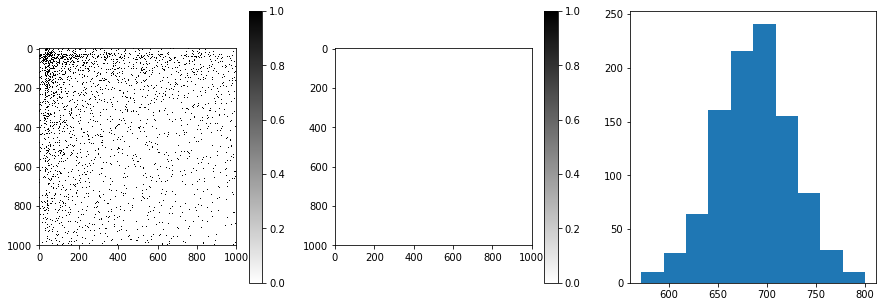

In [355]:
plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
plot_adj(ba_adj)
plt.subplot(1,3,2)
plot_adj(m.adj_matrix)
plt.subplot(1,3,3)
plt.hist([m.sample().sum() for i in trange(1000)])

## Subgraph connectivity

In [358]:
m = cl.GraphEnsemble(1000)
m.fit([const.Connectivity(343, nodeset1=np.arange(100))], opt_kwargs={'nit':30,'fatol':1e-2,'disp':True})

0:  |F(x)| = 560.006; step 1
1:  |F(x)| = 171.69; step 1
2:  |F(x)| = 69.2563; step 1
3:  |F(x)| = 25.781; step 1
4:  |F(x)| = 8.51555; step 1
5:  |F(x)| = 2.43688; step 1
6:  |F(x)| = 0.416235; step 1
7:  |F(x)| = 0.0340016; step 1
8:  |F(x)| = 0.00118581; step 1
9:  |F(x)| = 1.49332e-05; step 1
10:  |F(x)| = 5.7016e-08; step 1
11:  |F(x)| = 5.21823e-11; step 1
12:  |F(x)| = 0; step 1


/Users/reema/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=2.5467e-18): result may not be accurate.
  gamma = solve(self.a, df_f)


(array([  2.,  19.,  78., 150., 240., 251., 147.,  79.,  26.,   8.]),
 array([284. , 295.7, 307.4, 319.1, 330.8, 342.5, 354.2, 365.9, 377.6,
        389.3, 401. ]),
 <a list of 10 Patch objects>)

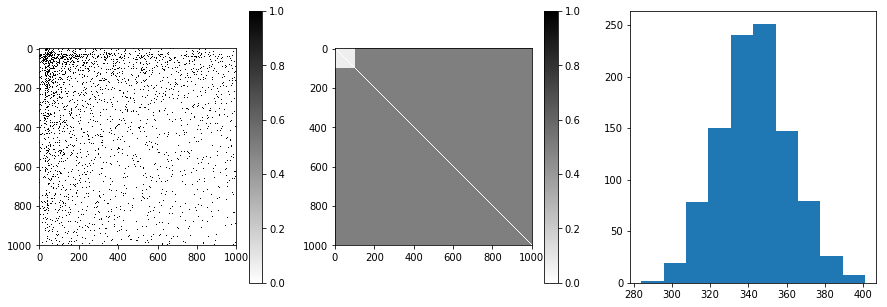

In [361]:
plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
plot_adj(ba_adj)
plt.subplot(1,3,2)
plot_adj(m.adj_matrix)
plt.subplot(1,3,3)
plt.hist([np.triu(m.sample()[:100,:100]).sum() for i in trange(1000)])

## Connectivity between 2 groups of nodes

In [322]:
m = cl.GraphEnsemble(1000)
m.fit([const.Connectivity(343, nodeset1=np.arange(100), nodeset2=np.arange(150,200))], opt_kwargs={'nit':30,'fatol':1e-2,'disp':True})

0:  |F(x)| = 569.128; step 1
1:  |F(x)| = 175.026; step 1
2:  |F(x)| = 70.9591; step 1
3:  |F(x)| = 26.5891; step 1
4:  |F(x)| = 8.85489; step 1
5:  |F(x)| = 2.55823; step 1
6:  |F(x)| = 0.443123; step 1
7:  |F(x)| = 0.0369602; step 1
8:  |F(x)| = 0.00132553; step 1
9:  |F(x)| = 1.73e-05; step 1
10:  |F(x)| = 6.90277e-08; step 1
11:  |F(x)| = 6.66205e-11; step 1
12:  |F(x)| = 0; step 1


/Users/reema/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=3.29922e-18): result may not be accurate.
  gamma = solve(self.a, df_f)


(array([  6.,  29.,  98., 197., 239., 235., 128.,  50.,  15.,   3.]),
 array([287. , 298.8, 310.6, 322.4, 334.2, 346. , 357.8, 369.6, 381.4,
        393.2, 405. ]),
 <a list of 10 Patch objects>)

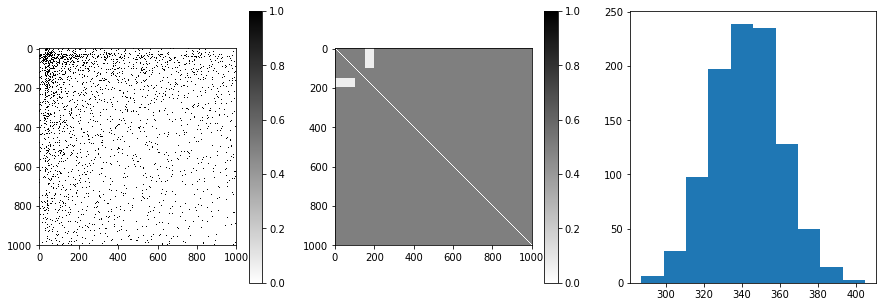

In [351]:
plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
plot_adj(ba_adj)
plt.subplot(1,3,2)
plot_adj(m.adj_matrix)
plt.subplot(1,3,3)
plt.hist([m.sample()[:100,150:200].sum() for i in trange(1000)])

# Fixed degree sequence

### Full degree sequence

In [363]:
m = cl.GraphEnsemble(1000)
m.fit([const.DegreeSequence(d)], opt_kwargs={'nit':100,'fatol':1e-2,'disp':True})
#m.fit([const.DegreeSequence(get_din_dout(ba)[0]),const.Connectivity(250, nodeset1=np.arange(30), nodeset2=np.arange(40,50))], opt_kwargs={'nit':100,'fatol':1e-2})
#m.fit([const.DegreeSequence(d[:30], nodeset=np.arange(30))], opt_kwargs={'nit':30,'fatol':1e-2})

0:  |F(x)| = 95.2099; step 1
1:  |F(x)| = 39.4397; step 1
2:  |F(x)| = 43.0774; step 1
3:  |F(x)| = 51.2111; step 1
4:  |F(x)| = 17.1113; step 0.317792
5:  |F(x)| = 31.0349; step 1
6:  |F(x)| = 3.00233; step 0.42723
7:  |F(x)| = 1.93187; step 1
8:  |F(x)| = 0.668765; step 1
9:  |F(x)| = 0.306068; step 1
10:  |F(x)| = 0.195956; step 1
11:  |F(x)| = 0.1027; step 1
12:  |F(x)| = 0.0654634; step 1
13:  |F(x)| = 0.0256601; step 1
14:  |F(x)| = 0.0170615; step 1
15:  |F(x)| = 0.0095704; step 1
16:  |F(x)| = 0.00601053; step 1
17:  |F(x)| = 0.00270145; step 1
18:  |F(x)| = 0.00174604; step 1
19:  |F(x)| = 0.00143383; step 1
20:  |F(x)| = 0.000865887; step 1
21:  |F(x)| = 0.000466886; step 1
22:  |F(x)| = 0.000324389; step 1
23:  |F(x)| = 0.000225038; step 1
24:  |F(x)| = 0.000119571; step 1
25:  |F(x)| = 8.40935e-05; step 1
26:  |F(x)| = 6.51684e-05; step 1
27:  |F(x)| = 4.81475e-05; step 1
28:  |F(x)| = 2.98291e-05; step 1
29:  |F(x)| = 1.96056e-05; step 1
30:  |F(x)| = 1.4626e-05; step 1
31

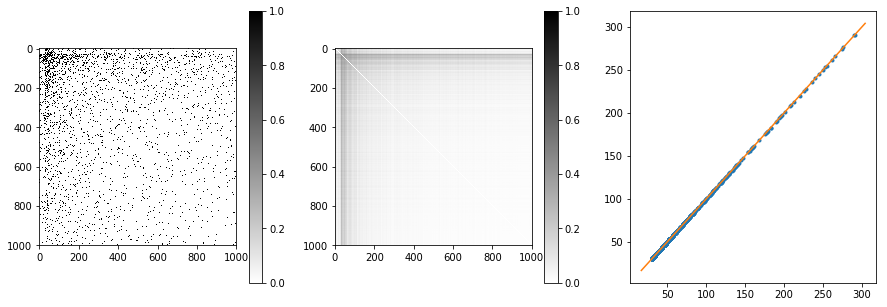

In [365]:
plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
plot_adj(ba_adj)
plt.subplot(1,3,2)
plot_adj(m.adj_matrix)
plt.subplot(1,3,3)
plt.plot(d, m.adj_matrix.sum(axis=1),'.')
plt.plot(plt.xlim(),plt.xlim())

### Partial degree sequence

In [366]:
m = cl.GraphEnsemble(1000)
m.fit([const.DegreeSequence(d[:50], nodeset=np.arange(50))], opt_kwargs={'nit':30,'fatol':1e-2,'disp':True})

0:  |F(x)| = 83.3477; step 1
1:  |F(x)| = 37.3218; step 1
2:  |F(x)| = 12.5101; step 1
3:  |F(x)| = 7.22436; step 1
4:  |F(x)| = 5.66524; step 1
5:  |F(x)| = 1.18083; step 1
6:  |F(x)| = 0.64922; step 1
7:  |F(x)| = 0.636525; step 1
8:  |F(x)| = 0.132351; step 1
9:  |F(x)| = 0.0242339; step 1
10:  |F(x)| = 0.00608303; step 1
11:  |F(x)| = 0.00241692; step 1
12:  |F(x)| = 0.0010748; step 1
13:  |F(x)| = 0.000282456; step 1
14:  |F(x)| = 9.46773e-05; step 1
15:  |F(x)| = 4.26601e-05; step 1
16:  |F(x)| = 8.4764e-06; step 1
17:  |F(x)| = 5.83775e-06; step 1
18:  |F(x)| = 2.40415e-06; step 1
19:  |F(x)| = 8.21601e-07; step 1
20:  |F(x)| = 4.49506e-07; step 1
21:  |F(x)| = 1.60551e-07; step 1
22:  |F(x)| = 4.49229e-08; step 1
23:  |F(x)| = 2.65026e-08; step 1
24:  |F(x)| = 1.05711e-08; step 1
25:  |F(x)| = 4.64952e-09; step 1
26:  |F(x)| = 1.66506e-09; step 1
27:  |F(x)| = 4.98517e-10; step 1
28:  |F(x)| = 2.93127e-10; step 1
29:  |F(x)| = 1.01409e-10; step 1


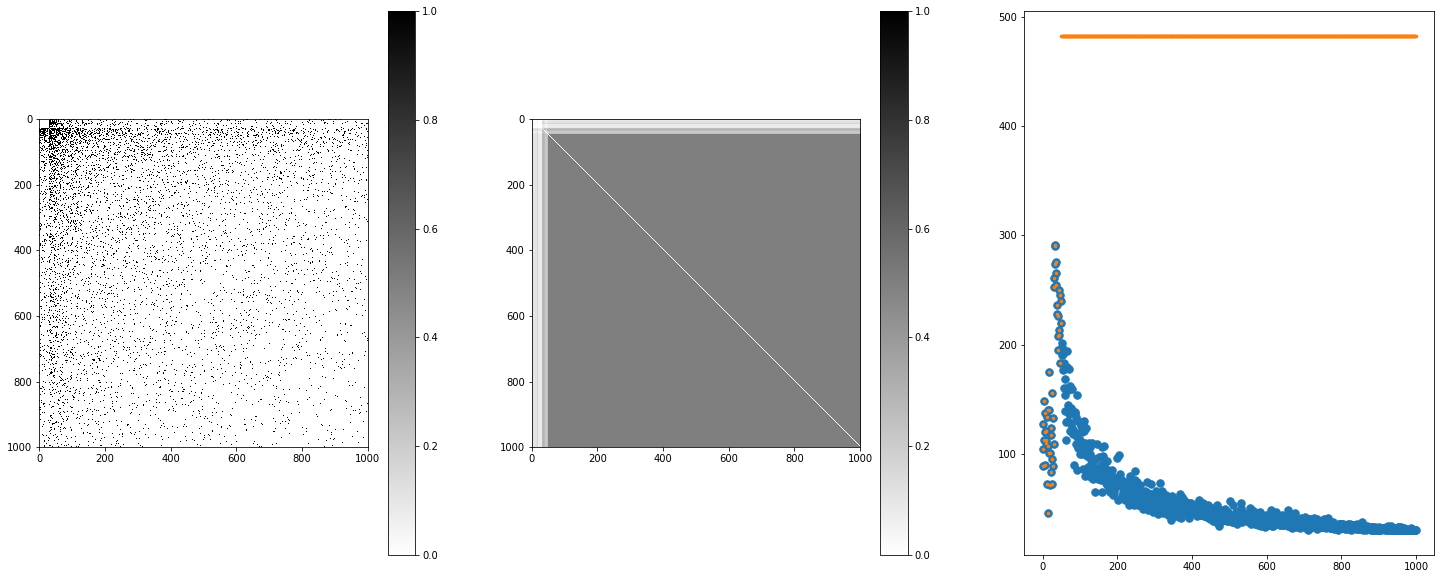

In [373]:
plt.figure(figsize=[25,10])
plt.subplot(1,3,1)
plot_adj(ba_adj)
plt.subplot(1,3,2)
plot_adj(m.adj_matrix)
plt.subplot(1,3,3)
plt.plot(d, '.', markersize=15)
plt.plot(m.adj_matrix.sum(axis=1),'.',markersize=5)

### Degree sequence in subgraph

In [384]:
m = cl.GraphEnsemble(1000)
m.fit([const.DegreeSequence(np.arange(50), nodeset=np.arange(50), subgraph_nodeset=np.arange(100))], opt_kwargs={'nit':100,'fatol':1e-2,'disp':True})

#m.fit([const.DegreeSequence(get_din_dout(ba)[0]),const.Connectivity(250, nodeset1=np.arange(30), nodeset2=np.arange(40,50))], opt_kwargs={'nit':100,'fatol':1e-2})
#m.fit([const.DegreeSequence(d[:50], nodeset=np.arange(50))], opt_kwargs={'nit':30,'fatol':1e-2})

0:  |F(x)| = 214.38; step 1
1:  |F(x)| = 178.029; step 1
2:  |F(x)| = 72.6727; step 1
3:  |F(x)| = 64.0719; step 1
4:  |F(x)| = 25.0385; step 1
5:  |F(x)| = 10.4284; step 1
6:  |F(x)| = 10.1086; step 1
7:  |F(x)| = 3.94414; step 1
8:  |F(x)| = 2.44604; step 1
9:  |F(x)| = 1.23035; step 1
10:  |F(x)| = 0.638202; step 1
11:  |F(x)| = 0.415216; step 1
12:  |F(x)| = 0.256825; step 1
13:  |F(x)| = 0.128082; step 1
14:  |F(x)| = 0.0718772; step 1
15:  |F(x)| = 0.0224668; step 1
16:  |F(x)| = 0.00445078; step 1
17:  |F(x)| = 0.00325643; step 1
18:  |F(x)| = 0.00339294; step 1
19:  |F(x)| = 0.00368964; step 1
20:  |F(x)| = 0.00241146; step 1
21:  |F(x)| = 0.00173473; step 1
22:  |F(x)| = 0.00141535; step 1
23:  |F(x)| = 0.00100512; step 1
24:  |F(x)| = 0.000610533; step 1
25:  |F(x)| = 0.000360735; step 1
26:  |F(x)| = 0.000225432; step 1
27:  |F(x)| = 0.000114244; step 1
28:  |F(x)| = 4.74289e-05; step 1
29:  |F(x)| = 1.74781e-05; step 1
30:  |F(x)| = 9.0451e-06; step 1
31:  |F(x)| = 1.00864e

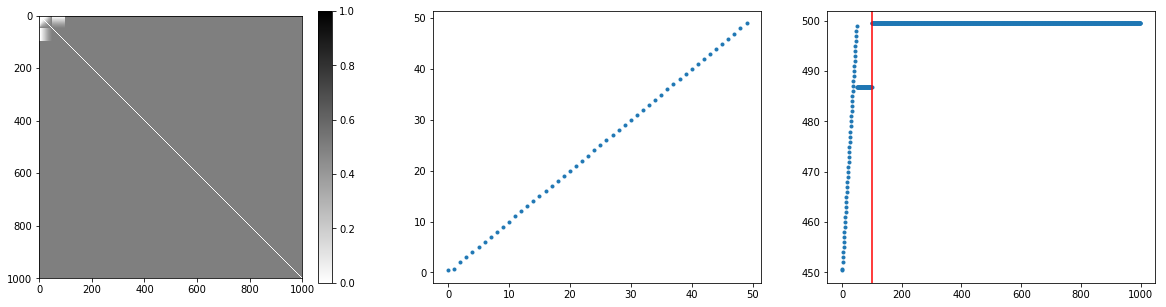

In [382]:
plt.figure(figsize=[20,5])
plt.subplot(1,3,1)
plot_adj(m.adj_matrix)
plt.subplot(1,3,2)
plt.plot(m.adj_matrix[:50,:100].sum(axis=1),'.')
plt.subplot(1,3,3)
plt.plot(m.adj_matrix.sum(axis=1),'.')
plt.axvline(100,color='red')

# Fixing edges

In [47]:
edges1 = np.asarray(np.meshgrid(np.arange(100),np.arange(100,200))).T.reshape(-1,2)
edges0 = np.asarray(np.meshgrid(np.arange(100,200),np.arange(300,400))).T.reshape(-1,2)

m = cl.GraphEnsemble(1000)
m.fix_edges_value(np.concatenate([edges0,edges1],axis=0), np.concatenate([np.zeros(len(edges0)),np.ones(len(edges1))]))
m.fit([const.Connectivity(150000)], opt_kwargs={'nit':30,'fatol':1e-2,'disp':True})

0:  |F(x)| = 9328.35; step 0.0362154
1:  |F(x)| = 248.751; step 1
2:  |F(x)| = 8.53801; step 1
3:  |F(x)| = 0.190824; step 1
4:  |F(x)| = 0.00320217; step 1
5:  |F(x)| = 4.2987e-05; step 1
6:  |F(x)| = 1.72673e-07; step 1
7:  |F(x)| = 8.73115e-11; step 1
8:  |F(x)| = 2.91038e-11; step 1


/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=1.3903e-17): result may not be accurate.
  gamma = solve(self.a, df_f)
/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=3.38767e-18): result may not be accurate.
  gamma = solve(self.a, df_f)
/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=4.78292e-20): result may not be accurate.
  gamma = solve(self.a, df_f)
/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=4.42378e-23): result may not be accurate.
  gamma = solve(self.a, df_f)


9:  |F(x)| = 2.91038e-11; step 1


/Users/reema/anaconda2/envs/claude/lib/python3.6/site-packages/scipy/optimize/nonlin.py:1132: LinAlgWarning: Ill-conditioned matrix (rcond=3.52703e-20): result may not be accurate.
  gamma = solve(self.a, df_f)


10:  |F(x)| = 2.91038e-11; step 1
11:  |F(x)| = 2.91038e-11; step 1
12:  |F(x)| = 2.91038e-11; step 1
13:  |F(x)| = 2.91038e-11; step 1
14:  |F(x)| = 2.91038e-11; step 1
15:  |F(x)| = 2.91038e-11; step 1
16:  |F(x)| = 2.91038e-11; step 1
17:  |F(x)| = 2.91038e-11; step 1
18:  |F(x)| = 2.91038e-11; step 1
19:  |F(x)| = 2.91038e-11; step 1
20:  |F(x)| = 2.91038e-11; step 1
21:  |F(x)| = 2.91038e-11; step 1
22:  |F(x)| = 2.91038e-11; step 1
23:  |F(x)| = 2.91038e-11; step 1
24:  |F(x)| = 2.91038e-11; step 1
25:  |F(x)| = 2.91038e-11; step 1
26:  |F(x)| = 2.91038e-11; step 1
27:  |F(x)| = 2.91038e-11; step 1
28:  |F(x)| = 2.91038e-11; step 1
29:  |F(x)| = 2.91038e-11; step 1


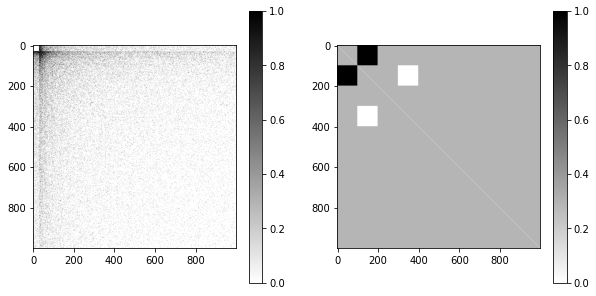

In [48]:
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plot_adj(ba_adj)
plt.subplot(1,2,2)
plot_adj(m.adj_matrix)

# Joining constraints

In [383]:
m = cl.GraphEnsemble(1000)
m.fit([const.DegreeSequence(get_din_dout(ba)[0]),const.Connectivity(250, nodeset1=np.arange(30), nodeset2=np.arange(40,50))], opt_kwargs={'nit':100,'fatol':1e-2,'disp':True})

0:  |F(x)| = 214.38; step 1
1:  |F(x)| = 178.029; step 1
2:  |F(x)| = 72.6727; step 1
3:  |F(x)| = 64.0719; step 1
4:  |F(x)| = 25.0385; step 1
5:  |F(x)| = 10.4284; step 1
6:  |F(x)| = 10.1086; step 1
7:  |F(x)| = 3.94414; step 1
8:  |F(x)| = 2.44604; step 1
9:  |F(x)| = 1.23035; step 1
10:  |F(x)| = 0.638202; step 1
11:  |F(x)| = 0.415216; step 1
12:  |F(x)| = 0.256825; step 1
13:  |F(x)| = 0.128082; step 1
14:  |F(x)| = 0.0718772; step 1
15:  |F(x)| = 0.0224668; step 1
16:  |F(x)| = 0.00445078; step 1
17:  |F(x)| = 0.00325643; step 1
18:  |F(x)| = 0.00339294; step 1
19:  |F(x)| = 0.00368964; step 1
20:  |F(x)| = 0.00241146; step 1
21:  |F(x)| = 0.00173473; step 1
22:  |F(x)| = 0.00141535; step 1
23:  |F(x)| = 0.00100512; step 1
24:  |F(x)| = 0.000610533; step 1
25:  |F(x)| = 0.000360735; step 1
26:  |F(x)| = 0.000225432; step 1
27:  |F(x)| = 0.000114244; step 1
28:  |F(x)| = 4.74289e-05; step 1
29:  |F(x)| = 1.74781e-05; step 1
30:  |F(x)| = 9.0451e-06; step 1
31:  |F(x)| = 1.00864e

(array([  9.,  19.,  78., 211., 244., 237., 157.,  36.,   8.,   1.]),
 array([230. , 234.3, 238.6, 242.9, 247.2, 251.5, 255.8, 260.1, 264.4,
        268.7, 273. ]),
 <a list of 10 Patch objects>)

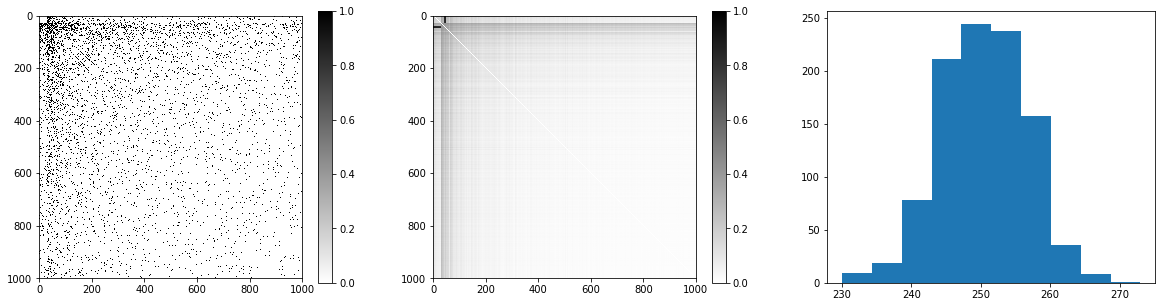

In [385]:
plt.figure(figsize=[20,5])
plt.subplot(1,3,1)
plot_adj(ba_adj)
plt.subplot(1,3,2)
plot_adj(m.adj_matrix)
plt.subplot(1,3,3)
plt.hist([m.sample()[:30,40:50].sum() for i in trange(1000)])

# Observables

### RWR

In [7]:

x = np.zeros(N)
x[np.random.randint(0,N, int(N/100*20))] = 1
#x = np.random.rand(N)
x= x/x.sum()
x = jnp.asarray(x)

lambd = 0.3

def propagate(adj,x,lambd=lambd):
    p = adj / jnp.reshape(adj.sum(axis=0), [adj.shape[0],1])
    I = jnp.eye(p.shape[0])
    return lambd*x.dot(jnp.linalg.inv(I - (1-lambd)*p))

def propagate2(adj,x,i,lambd=lambd):
    p = adj / jnp.reshape(adj.sum(axis=0), [adj.shape[0],1])
    I = jnp.eye(p.shape[0])
    return lambd*x.dot(jnp.linalg.inv(I - (1-lambd)*p))[i]

In [8]:
m = cl.GraphEnsemble(1000)
#m.fit([const.DegreeSequence(d)], opt_kwargs={'nit':100,'fatol':1e-2})
m.fit([const.DegreeSequence(d),const.Connectivity(250, nodeset1=np.arange(30), nodeset2=np.arange(40,50))], opt_kwargs={'nit':50,'fatol':1e-2,'disp':True})

0:  |F(x)| = 214.194; step 1
1:  |F(x)| = 177.594; step 1
2:  |F(x)| = 66.784; step 1
3:  |F(x)| = 64.2562; step 1
4:  |F(x)| = 22.4106; step 1
5:  |F(x)| = 10.5481; step 1
6:  |F(x)| = 10.4923; step 1
7:  |F(x)| = 4.04977; step 1
8:  |F(x)| = 2.44804; step 1
9:  |F(x)| = 1.3813; step 1
10:  |F(x)| = 0.836161; step 1
11:  |F(x)| = 0.638925; step 1
12:  |F(x)| = 0.432116; step 1
13:  |F(x)| = 0.24552; step 1
14:  |F(x)| = 0.177947; step 1
15:  |F(x)| = 0.102684; step 1
16:  |F(x)| = 0.0672128; step 1
17:  |F(x)| = 0.0427552; step 1
18:  |F(x)| = 0.0243624; step 1
19:  |F(x)| = 0.0110056; step 1
20:  |F(x)| = 0.00546293; step 1
21:  |F(x)| = 0.00388942; step 1
22:  |F(x)| = 0.00293664; step 1
23:  |F(x)| = 0.00187461; step 1
24:  |F(x)| = 0.0011223; step 1
25:  |F(x)| = 0.000965737; step 1
26:  |F(x)| = 0.00085804; step 1
27:  |F(x)| = 0.000686768; step 1
28:  |F(x)| = 0.000490172; step 1
29:  |F(x)| = 0.000312658; step 1
30:  |F(x)| = 0.000159809; step 1
31:  |F(x)| = 6.47321e-05; step 

In [9]:
k = obs.RandomWalkWithRestart.eval_transfer_matrix(ba_adj, lambd)

In [10]:
mu = m.predict_mean(obs.RandomWalkWithRestart.func, f_args=[x, lambd, None, k])

In [11]:
sigma = m.predict_std(obs.RandomWalkWithRestart.grad, f_args=[x, lambd, None, k], obs_dim_idx=1)

In [13]:
N_samples = 100
y = propagate(ba_adj, x)
#samples = []
rdmy_ms = np.zeros([len(ba),N_samples])
for i in trange(N_samples):
    flag = False
    while not flag:
        smpl = m.sample()
        prop = propagate(smpl,x,lambd)
        if np.isnan(propagate(smpl,x)).sum() == 0:
            #samples.append(smpl)
            rdmy_ms[:,i] = propagate(smpl, x)
            flag = True
    
z = (y - rdmy_ms.mean(axis=1))/rdmy_ms.std(axis=1)

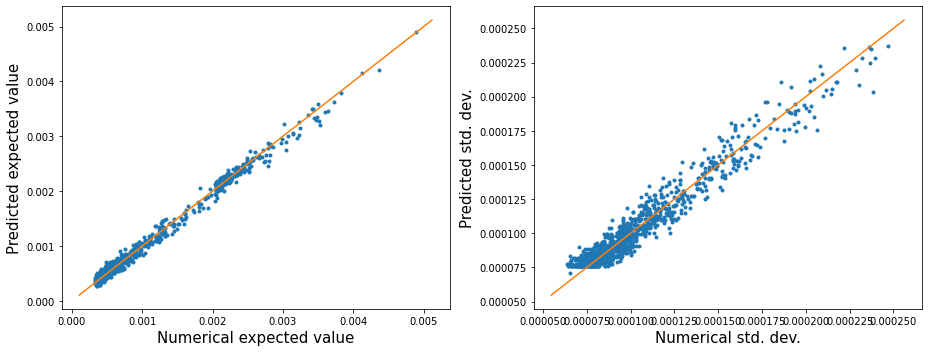

In [14]:
plt.figure(figsize=[13,5])
plt.subplot(121)
plt.plot(rdmy_ms.mean(axis=1),mu,'.')
plt.xlabel('Numerical expected value',fontsize=15)
plt.ylabel('Predicted expected value',fontsize=15)
plt.plot(plt.xlim(),plt.xlim())
plt.subplot(122)
plt.plot(rdmy_ms.std(axis=1),sigma,'.')
plt.xlabel('Numerical std. dev.',fontsize=15)
plt.ylabel('Predicted std. dev.',fontsize=15)
plt.plot(plt.xlim(),plt.xlim())
plt.tight_layout()

### ANND

In [415]:
mu = m.predict_mean(obs.AverageNeighborDegree.func)

In [416]:
sigma = [m.predict_std(grad(obs.AverageNeighborDegree.func, argnums=0), f_args=[i]) for i in trange(N)]

In [417]:
annd = obs.AverageNeighborDegree.func
N_samples = 100
y = np.asarray(annd(csc_matrix(adj))).flatten()
#samples = []
rdm_annd = np.zeros([N,N_samples])
for i in trange(N_samples):
    smpl = csc_matrix(m.sample())
    prop = np.asarray(annd(smpl)).flatten()
    rdm_annd[:,i] = prop
    
z = (y - rdm_annd.mean(axis=1))/rdm_annd.std(axis=1)

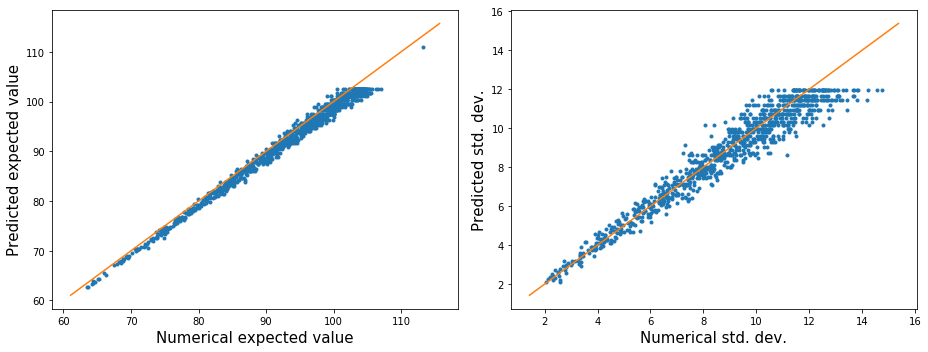

In [418]:
plt.figure(figsize=[13,5])
plt.subplot(121)
plt.plot(rdm_annd.mean(axis=1),mu,'.')
plt.xlabel('Numerical expected value',fontsize=15)
plt.ylabel('Predicted expected value',fontsize=15)
plt.plot(plt.xlim(),plt.xlim())
plt.subplot(122)
plt.plot(rdm_annd.std(axis=1),sigma,'.')
plt.xlabel('Numerical std. dev.',fontsize=15)
plt.ylabel('Predicted std. dev.',fontsize=15)
plt.plot(plt.xlim(),plt.xlim())
plt.tight_layout()